# Image Captioning with Tensorflow*
##Glove Embedding, InceptionV3 Convolution

Source code based on: https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_captioning.ipynb

## Load libraries/packages

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

import collections, re
import random
import numpy as np
import pandas as pd
import os
import datetime,time
import json
import string
import pickle
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from glob import glob

from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sys import getsizeof
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
sns.set_style("whitegrid")
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3
import tensorflow.keras.preprocessing.image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Load Dataset

## (Not Used) MS-COCO
* Contains 82,000 images, each has at least 5 different caption annotations


In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

101113856/252872794 [==========>...................] - ETA: 11s

KeyboardInterrupt: ignored

For a smaller training set

In [ ]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Flickr8k
* Contains 8,092 images, each has at least 5 different caption annotations

In [4]:
root_dir = '/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr'
image_dir_name = os.path.join(root_dir,'Flickr8k_Dataset')
caption_file_name = os.path.join(root_dir,'Flickr8k_text/Flickr8k.token.txt')

*Take around 2mins to run*

In [ ]:
# caption_file = open(caption_file_name, 'r')
# caption_file_content = caption_file.read()
# caption_file.close()

# Create a lookup dict with image name as key and 5 descriptions as value
# caption_lookup = dict()
# table = str.maketrans('', '', string.punctuation)
# caption_df = pd.DataFrame(columns=['img_id', 'clean_caption'])

# max_length = 0
# for row in caption_file_content.split('\n'):
#   tokens = row.split()
#   if len(row) < 2:
#     continue
#   img_id, img_desc = tokens[0], tokens[1:]
#   img_id = img_id.split('.')[0]

#   img_desc = [word.lower() for word in img_desc]
#   img_desc = [w.translate(table) for w in img_desc]
#   #img_desc = [word for word in img_desc if len(word)>1]
#   img_desc = [word for word in img_desc if word.isalpha()]
#   img_desc = ' '.join(img_desc)
#   max_length = max(max_length,len(img_desc))

#   caption_df.loc[len(caption_df)] = [img_id, img_desc]

#   if img_id not in caption_lookup:
#     caption_lookup[img_id] = list()
#   caption_lookup[img_id].append(img_desc)

# caption_df.head(10)

,img_id,clean_caption
0,1000268201_693b08cb0e,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,a girl going into a wooden building
2,1000268201_693b08cb0e,a little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,a little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70,a black dog and a spotted dog are fighting
6,1001773457_577c3a7d70,a black dog and a tricolored dog playing with ...
7,1001773457_577c3a7d70,a black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70,two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70,two dogs on pavement moving toward each other


In [5]:
path = '/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr/caption_lookup.pkl'
# with open(path, "wb") as fp:
#       pickle.dump(caption_lookup, fp)
with open(path, "rb") as fp:
      caption_lookup = pickle.load(fp)

# Preprocessing Stage

## Text Preprocessing

In [6]:
# Load Glove Embedding
images = glob(os.path.join(image_dir_name, '*.jpg'))
len(images)

# Use Predefined train/test sets
train_images_path = os.path.join(root_dir,'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_dir, 'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
train_img, test_img = [], []
train_img_full, test_img_full = [], []

for i in images:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
    train_img_full.append(i)
  elif f in test_images:
    test_img.append(f)
    test_img_full.append(i)

print('Train image size:',len(train_images))
print('Test image size:',len(test_images))

Train image size: 6000
Test image size: 1000


In [7]:
# Build the sequence and include start/stop token at the beginning/end
START = "startseq" # Use to begin the process of generating caption
STOP = "endseq" # Let us know when the process is complete
train_descriptions = {k:v for k,v in caption_lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'
#max_length += 2 # for the two new tokens
max_length = 194
print("Maximum Length of Caption:", max_length)

Maximum Length of Caption: 194


In [8]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

# Remove misleading word (words that occur less than ten times)
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7589 ==> 1654


In [9]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1655

## Image Extraction - InceptionV3

In [10]:
USE_INCEPTION = True

In [11]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96116736/96112376 [==============================] - 1s 0us/step


In [12]:
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
# Image to Vector
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image 
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM ) # output dim 2048
  return x

Generate train and pickle

In [14]:
def preprocess_data(type=str, images_id=list):
  path = os.path.join(root_dir,type +'.pkl')
  if not os.path.exists(path):
    encoding = {}
    for id in images_id:
      #image_path = os.path.join(root_dir,'Flicker8k_Dataset', id)
      img = tensorflow.keras.preprocessing.image.load_img(id, target_size=(HEIGHT, WIDTH))
      encoding[id] = encodeImage(img)
    with open(path, "wb") as fp:
      pickle.dump(encoding, fp)
  else:
    with open(path, "rb") as fp:
      encoding = pickle.load(fp)
  return encoding

In [15]:
#full_image = preprocess_data(type='full', images_id=images)
# Load pickle file instead of running
full_image = pickle.load(open('/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr/full.pkl', 'rb'))

In [16]:
# Split into training and testing
filterByKey = lambda keys: {x: full_image[x] for x in keys}
encoding_train = filterByKey(train_img_full)
encoding_test = filterByKey(test_img_full)

# Embedding Stage

## Glove (Embedding Method)
* Using the glove.6B file containing Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 300d vectors, 822 MB download)
* Official Site: https://nlp.stanford.edu/projects/glove/

In [17]:
glove_dir = '/content/gdrive/Shareddrives/258 Deep Dreamers/data/'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:31, 12750.24it/s]

Found 400000 word vectors.


In [18]:
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix.shape

(1655, 200)

# Tensorflow Model

## Building the NN
Architecture include: 
* Dropout
* LSTM 

Things to try:
* Fine-tune model on different images, use a bigger learning rate to not lose trained weight info
* Add attention layer

In [20]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [21]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [22]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 194)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 194, 200)     331000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

## Training the NN

Data Formatting

In [23]:
def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos (vectors)
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[image_dir_name+'/'+key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

In [ ]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
EPOCHS = 2

Model loads previous saved weights, if not there then it would run a new one

*Takes around 1 hour to run*

In [26]:
model_path = '/content/gdrive/Shareddrives/258 Deep Dreamers/data/caption-model.hdf5'
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

# Evaluation Metrics

## Evaluation Metrics

### [BLEU](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/) (Bilingual Evaluation Understudy Score) Score
* Calculates overlapping words and weight more to sequential words

*1.0 highest for perfect match, 0.0 lowest for perfect mismatch*

In [79]:
from nltk.translate.bleu_score import corpus_bleu
def bleu_score(image, pred):
  predictions = pred.split()
  actual, predicted = [], [predictions]
  #for ref in caption_lookup[pic[76:][:-4]]:
  for ref in caption_lookup['247097023_e656d5854d']:
    ref = ref.split()
    actual.append(ref)
  references = [actual]
  print('Real Caption:', ' '.join(actual[0]))
  print('Real Caption:', ' '.join(actual[1]))
  print('Real Caption:', ' '.join(actual[2]))
  print('Real Caption:', ' '.join(actual[3]))
  print('Real Caption:', ' '.join(actual[4]))
  print('Prediction Caption:', pred)
  print()
  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(references, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(references, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(references, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(references, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

### [GLEU](https://colab.research.google.com/github/gcunhase/NLPMetrics/blob/master/notebooks/gleu.ipynb) (Google BLEU)
* Recall: number of Matching n-grams/Number of Total n-grams in the reference
* Precision: number of matching n-grams/number of total n-grams generated caption

*1.0 highest for perfect match, 0.0 lowest for perfect mismatch*

In [80]:
import nltk.translate.gleu_score as gleu
def gleu_score(image, pred):
  predictions = pred.split()
  actual, predicted = [], [predictions]
  #for ref in caption_lookup[pic[76:][:-4]]:
  for ref in caption_lookup['247097023_e656d5854d']:
    ref = ref.split()
    actual.append(ref)
  references = [actual]
  # calculate GLEU score
  print('GLEU: %f' % gleu.corpus_gleu(references, predicted))

### [WER](https://colab.research.google.com/github/gcunhase/NLPMetrics/blob/master/notebooks/wer.ipynb) (Word Error Rate)
The formula to calculate WER consist of 4 main components: 
* Substitution: number of words need to be substituted to match reference
* Deletion: number of words dropped from the reference
* Insertion: number of extra words added compared to the reference
* Number the total number of correct words


> Final formula = (S+D+I)/N


*The smaller the value, the better the prediction*

In [81]:
def wer_score(image, predictions):
  references  = []
  #for ref in caption_lookup[pic[76:][:-4]]:
  for ref in caption_lookup['247097023_e656d5854d']:
    ref = ref.split()
    references.append(ref)
  # calculate WER score for each reference
  predictions = predictions.split()
  wer_scores = []
  for ref in references:
    N = len(predictions)
    M = len(ref)
    L = np.zeros((N,M))
    for i in range(0, N):
      for j in range(0, M):
        if min(i,j) == 0:
          L[i,j] = max(i,j)
        else:
          deletion = L[i-1,j] + 1
          insertion = L[i,j-1] + 1
          sub = 1 if predictions[i] != ref[j] else 0
          substitution = L[i-1,j-1] + sub
          L[i,j] = min(deletion, min(insertion, substitution))
    wer_scores.append(int(L[N-1, M-1]))
  print('Average WER: %f' % np.mean(wer_scores))

# Prediction 
Load everything before running prediction

In [27]:
# Image to Vector
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image 
  # Shape to correct form to be accepted by LSTM captioning network.
  x = np.reshape(x, OUTPUT_DIM ) # output dim 2048
  return x

def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## On Flicker8k Testing

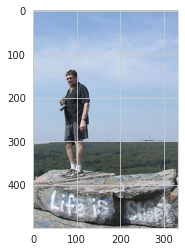

Real Caption: startseq a man in a dark shirt and shorts is standing on top of a high graffitied rock endseq
Real Caption: startseq a man in black standing on a rock with the phrase life is short spray painted on it endseq
Real Caption: startseq a man is standing on rocks which are inscribed with the phrase life is short on the side endseq
Real Caption: startseq a man stands on a rock and takes in the view endseq
Real Caption: startseq a man wearing a black shirt is standing on top of a rock that says life is short endseq
Prediction Caption: a man in a red shirt is standing on a rock overlooking a waterfall

BLEU-1: 0.714286
BLEU-2: 0.662994
BLEU-3: 0.634741
BLEU-4: 0.494800
GLEU: 0.271429
Average WER: 13.400000


In [83]:
#pic = list(encoding_test.keys())[100]
pic = '/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr/Flickr8k_Dataset/247097023_e656d5854d.jpg'
image = encoding_train[pic].reshape((1,OUTPUT_DIM))
result = generateCaption(image)
x=plt.imread(os.path.join(root_dir,'Flicker8k_Dataset', pic))
plt.imshow(x)
plt.show()
bleu_score(pic, result)
gleu_score(pic, result)
wer_score(pic, result)

/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr/Flickr8k_Dataset/3591462960_86045906bd.jpg


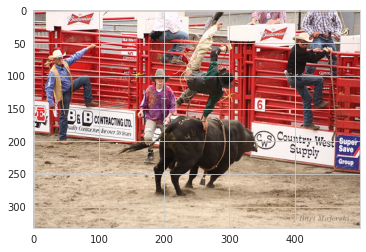

Caption: a man is sitting on a bench with a brown dog
_____________________________________
/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr/Flickr8k_Dataset/106490881_5a2dd9b7bd.jpg


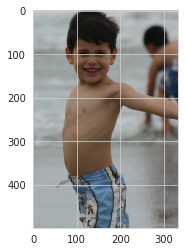

Caption: a young boy in a pink bathing suit is jumping into a pool
_____________________________________
/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr/Flickr8k_Dataset/2484190118_e89363c465.jpg


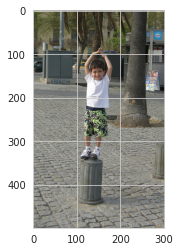

Caption: a woman in a pink shirt and a white shirt is walking down a street
_____________________________________
/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr/Flickr8k_Dataset/2542662402_d781dd7f7c.jpg


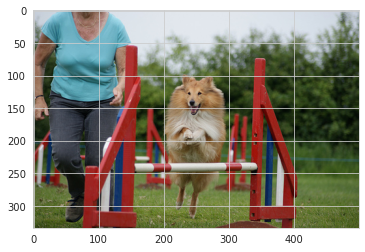

Caption: a dog jumps over a hurdle
_____________________________________
/content/gdrive/Shareddrives/258 Deep Dreamers/data/flickr/Flickr8k_Dataset/3191135894_2b4bdabb6d.jpg


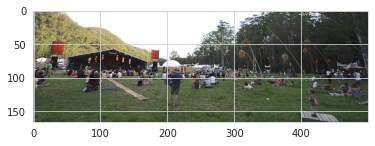

Caption: a group of people are walking on a grassy path
_____________________________________


In [29]:
for z in range(5): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_dir,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_dir,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

## On Outside Image

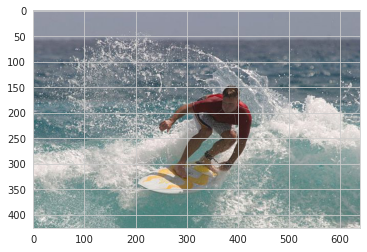

(1, 2048)
Caption: a man in a wetsuit is surfing
_____________________________________


In [28]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline
urls = ['https://tensorflow.org/images/surf.jpg']

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()
  plt.imshow(img)
  plt.show()

  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")